In [1]:
import seaborn as sns
import pandas as pd
# import numpy as np
import scipy
from scipy.stats import ks_2samp
import networkx as nx
from networkx.algorithms import bipartite
# import matplotlib
%pylab inline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict, cross_val_score

Populating the interactive namespace from numpy and matplotlib


# Question 01: Propensity Score matching

### 01 naive analysis
Let's start by loading in our data

In [2]:
df_lalonde = pd.read_csv(r'lalonde.csv')
df_lalonde.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


Let's have a quick look at our data with describe(). We can already note a few aspects of interest
* We're looking mostly at young people, an average of 27 years with 1st and 3rd quartiles at 20 and 32 respectively
* About 60% of the subjects don't have a degree
* About 40% of the subjects are black and 10% hispanic
* If we look at the mean revenue in 1974 and 75 we can see a big fall, which isn't too surprising as this was right during the oil crisis and the [73-75 recession](https://en.wikipedia.org/wiki/1973%E2%80%9375_recession). By 1976 this recession was over and GDP reached it's pre-1973 level, explaining the much higher salaries in 78

In [3]:
df_lalonde.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


Let's have a look at how many of the subjects actually had a job in '78 (ie. income greater than 0).

It looks the vast majority were employed:

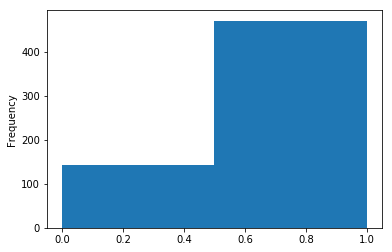

In [4]:
# Adding column with employment status and looking at unemployment
df_lalonde['em78'] = df_lalonde['re78']
df_lalonde.em78 = df_lalonde.em78.apply(lambda x: x if x == 0 else 1)
df_lalonde.em78.plot(kind='hist', bins=2)

We'll make two `DataFrames`, one with the treated subjects and the other with non-treated subjects. Then let's `describe()` the revenues in '78 of these two groups.

It looks like most metrics are very close, even the standard deviation is similar. It's hard to say from this analysis of the two groups if the treatment had any effect. Both means and medians are very similar, the no-treat group has larger quartiles, but then again it is also much bigger in # of samples.

In [5]:
df_treat = df_lalonde[df_lalonde['treat']==1]
df_notreat = df_lalonde[df_lalonde['treat']==0]

df_new = pd.DataFrame(index=df_treat.describe().index, columns=['treat re78','notreat re78'])
# df_new = df_treat.re78.describe()
df_new.loc[:, 'treat re78'] = df_treat.describe()['re78'].values
df_new.loc[:, 'notreat re78'] = df_notreat.describe()['re78'].values
df_new

,treat re78,notreat re78
count,185.000000,429.000000
mean,6349.143530,6984.169742
std,7867.402218,7294.161791
min,0.000000,0.000000
25%,485.229800,220.181300
50%,4232.309000,4975.505000
75%,9642.999000,11688.820000
max,60307.930000,25564.670000


Maybe a histogram or cumulative histogram will give us a better insight into these two groups.

Unfortunately it doesn't look there is much of a difference between the groups here either. There are a few outliers in the treated group with very high salaries, but that's it.

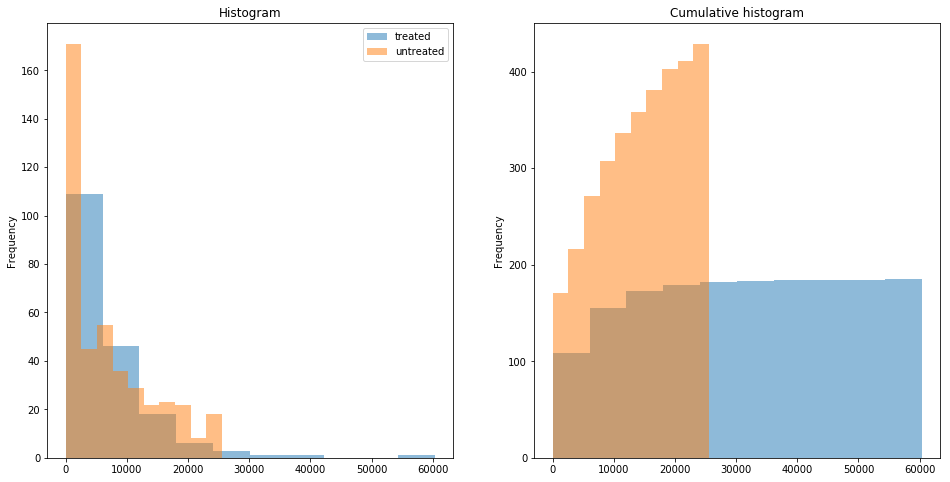

In [6]:
fig, axes = plt.subplots(1, 2)
df_treat.re78.plot(kind='hist', ax=axes[0], title='Histogram', label='treated', alpha=0.5, figsize=(16,8))
df_notreat.re78.plot(kind='hist', ax=axes[0], label='untreated', alpha=0.5)
axes[0].legend()

df_treat.re78.plot(kind='hist', cumulative=True, ax=axes[1], title='Cumulative histogram', label='treated', alpha=0.5)
df_notreat.re78.plot(kind='hist', cumulative=True, ax=axes[1], label='untreated', alpha=0.5)

Just looking at the histograms, means and medians it looks like the treatment doesn't really have any effect. One bothersome note for the histograms is that we have a lot more samples for the non-treated population, which makes it harder to compare.

Given the histograms, the revenue is clearly not normally distributed. Furthermore, the samples are of different sizes, so we would have to use the Mann-Whitney U test to try and estimate if the treated and untreated populations have a different revenue. As we can see from the returned p value close to 0.3, we cannot discard the null hypothesis that these two samples are drawn from the same population. If we follow the naive reasoning we may then conclude that these populations are in fact the same and that the treatment had no effect

In [7]:
stat, pval = scipy.stats.mannwhitneyu(df_treat.re78.values, df_notreat.re78.values, alternative='two-sided')
print(stat,'\n',pval)

37525.0 
 0.281773168081


### 02 A closer look at the data
We're now interested in distributions of variables within our two sets. For a quick look over our set let's plot a heatmap of the correlation between all our variables. What we're really interested in is whether a subject is treated or not is correlated to any other of the subject's features. This is represented by the leftmost column and uppermost row of our heatmap. The other correlations aren't directly of interest, but may pick up additional interesting aspects of the data.

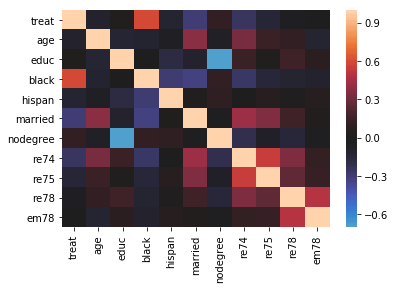

In [8]:
sns.heatmap(df_lalonde.corr().values, center=0, 
            xticklabels=df_lalonde.columns[1:], yticklabels=df_lalonde.columns[1:])

There's a very large correlation between treatment and whether a subject is black. The other two important correlations are marital status and revenue in '74. Let's plot these three attributes and see what they're like between our two groups.

Looks like our non-treated group was mostly comprised of non-blacks who already had a higher revenue in '74. While the untreated group was roughly 50/50 married or not, the treated was largely non-married. This is a huge difference between these two groups. If we're trying to evaluate the effect of the treatment based on these two groups, we're starting with a large bias, attempting to compare apples and oranges. We therefore shouldn't trust conclusions made from these two sets as-is.

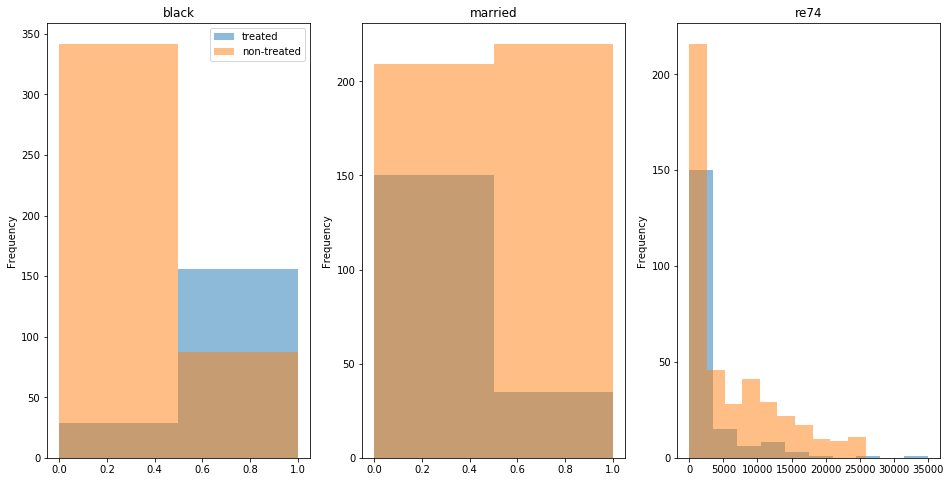

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 8))
df_treat.black.plot(kind='hist', bins=2, ax=axes[0], alpha=0.5, 
                    title='black', label='treated')
df_notreat.black.plot(kind='hist', bins=2, ax=axes[0], alpha=0.5, label='non-treated')
axes[0].legend()
df_treat.married.plot(kind='hist', bins=2, ax=axes[1], alpha=0.5,
                      title='married', label='treated')
df_notreat.married.plot(kind='hist', bins=2, ax=axes[1], alpha=0.5, label='non-treated')

df_treat.re74.plot(kind='hist', ax=axes[2], alpha=0.5,
                     title='re74', label='treated')
df_notreat.re74.plot(kind='hist', ax=axes[2], alpha=0.5, label='non-treated')

Let's have a quick check that we're not being misled by our correlation coefficient by having a look at some attributes which don't seem to be correlated with treatment, for example hispanic, age and education.

Looks good, there appears to be about the same distribution of these three attributes in both groups.

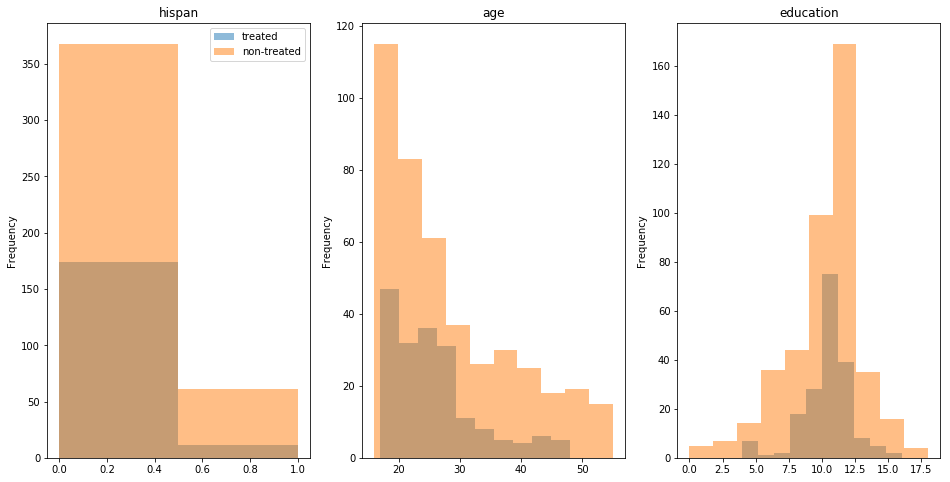

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 8))

df_treat.hispan.plot(kind='hist', bins=2, ax=axes[0], alpha=0.5,
                     title='hispan', label='treated')
df_notreat.hispan.plot(kind='hist', bins=2, ax=axes[0], alpha=0.5, label='non-treated').legend()

df_treat.age.plot(kind='hist', ax=axes[1], alpha=0.5,
                      title='age', label='treated')
df_notreat.age.plot(kind='hist', ax=axes[1], alpha=0.5, label='non-treated')

df_treat.educ.plot(kind='hist', ax=axes[2], alpha=0.5,
                     title='education', label='treated')
df_notreat.educ.plot(kind='hist', ax=axes[2], alpha=0.5, label='non-treated')

### 03 A propensity score model
To account for any variations in features between treated and control sets, we'd now like to estimate the probability of treatment of a subject given their features. As shown in the tutorial we'll train a logistic regression on all the features we have in order to predict the treatment probability (propensity score) of a subject given a set a of features.

In [11]:
df_lalonde.columns
features = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree']
x = pd.get_dummies(df_lalonde[features])
y = df_lalonde['treat']

logistic = LogisticRegression()
logistic.fit(x,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

It's a good idea to check the precision and recall of our logistic regression, so that we may actually base some conclusions off of it later:

In [12]:
precision = cross_val_score(logistic, x, y, cv=10, scoring="precision")
recall = cross_val_score(logistic, x, y, cv=10, scoring="recall")

print("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))

Precision: 0.69 (+/- 0.32)
Recall: 0.70 (+/- 0.24)


We have a decent but not great precision and recall of about 70%, meaning that about 70% of our positive treatment guesses based on subject features are in fact correct, and that we identify about 70% of all treated subjects.

We can even see that the propensity scores are very clearly split, ie. there is a very clear divide in attributes which makes it highly likely or unlikely a subject will be treated. Our logistic regression takes decisions in a rather categorical way, not often giving 'I'm not sure' answers.

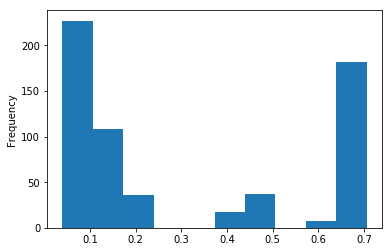

In [13]:
# output from predict proba is in same order as self.classes_
df_lalonde['propensity_score'] = logistic.predict_proba(x)[:,1]
df_lalonde.head()

df_lalonde.propensity_score.plot(kind='hist')

### 04 Balancing the dataset via matching
We now want to match our treat and control groups. In graph theory terms what we want is a bipartite graph, where edges can only exist between upper and lower nodes. In our case the upper and lower nodes represent the treat and control groups. We then want to match between these two groups so that the difference in propensity scores is minimised. We had a look through the `networkx` package, which has a great collection of algorithms and methods to create and work with graphs. But the issue of having identical propensity scores made a simpler greedy algorithm a lot more appealing, so we went with that instead.

In [14]:
df_treat = df_lalonde[df_lalonde['treat']==1]
df_notreat = df_lalonde[df_lalonde['treat']==0]

In [15]:
if len(df_notreat.propensity_score) != len(df_notreat.propensity_score.unique()):
    print('There are several subjects with identical propensity scores!')

There are several subjects with identical propensity scores!


In order to perform our matching we'll use a greedy algorithm inspired from [Kellie Ottoboni](http://nbviewer.jupyter.org/github/kellieotto/StatMoments/blob/master/PSM.ipynb). This algorithm works as follows:
* reshuffle the order of the treat group
* iterate through the treat group and match one subject from the control with the most similar propensity score
* This subject is then discarded from the control group and the iteration continues

Often a caliper is implemented, that is if the distance between a potential match is over a certain limit (propensity scores are too different), that match is discarded. However, in this case we are asked to match every subject from the treat group, so we won't use a caliper.

In [16]:
g1, g2 = df_treat.propensity_score, df_notreat.propensity_score
N1, N2 = df_treat.index, df_notreat.index
# Randomly permute the smaller group to get order for matching,
# we'd get the same matching everytime otherwise
morder = np.random.permutation(N1)
matches = {}

    
for m in morder:
    dist = abs(g1[m] - g2)
    matches[m] = dist.argmin()
    g2 = g2.drop(matches[m])
len(matches)

185

We can already see that there are several matches which have very different propensity scores, diverging by more than 0.5. This will surely pose a problem when trying to compare these sets. A caliper would have avoided these very different 'matches' at the cost of ending up with fewer matches.

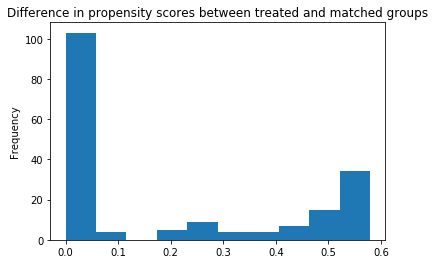

In [17]:
g2 = df_notreat.propensity_score
g2 = g2[list(matches.values())]
df_compare = pd.concat([df_treat.rename(columns=lambda x: x+'_treat'), df_notreat.loc[g2.index].reset_index()], axis=1)

df_compare['difference'] = abs(g1.values - g2.values)
df_compare.difference.plot(kind='hist', title='Difference in propensity scores between treated and matched groups')

If we plot the correlation heatmaps again we can see if our previous highly correlated attributes (black, married, revenue in '74) are now more evenly spread between our two groups. The heatmap on the right is our non matched groups, and the one on the left the new matched groups.

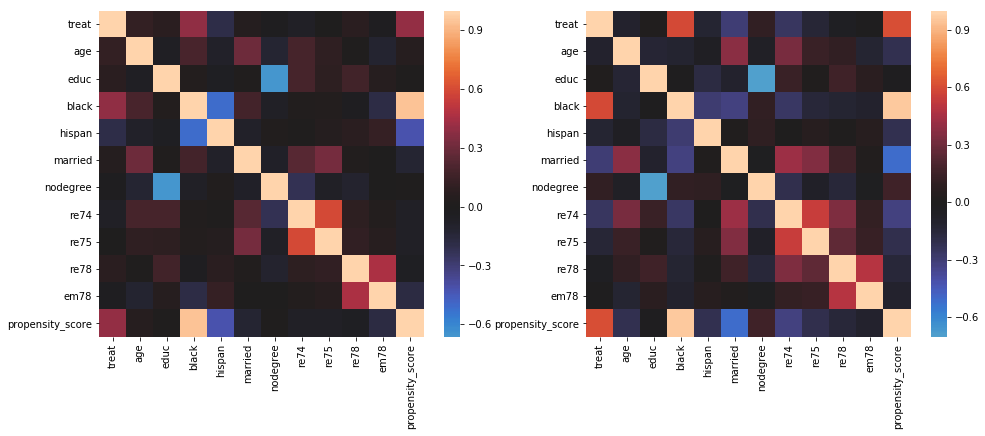

In [18]:
df_match = df_lalonde.loc[g2.index]
fig, axes = fig, axes = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(pd.concat([df_match, df_treat]).corr(), center=0, ax=axes[0],
            xticklabels=df_lalonde.columns[1:], yticklabels=df_lalonde.columns[1:])
sns.heatmap(df_lalonde.corr(), center=0, ax=axes[1],
             xticklabels=df_lalonde.columns[1:], yticklabels=df_lalonde.columns[1:])

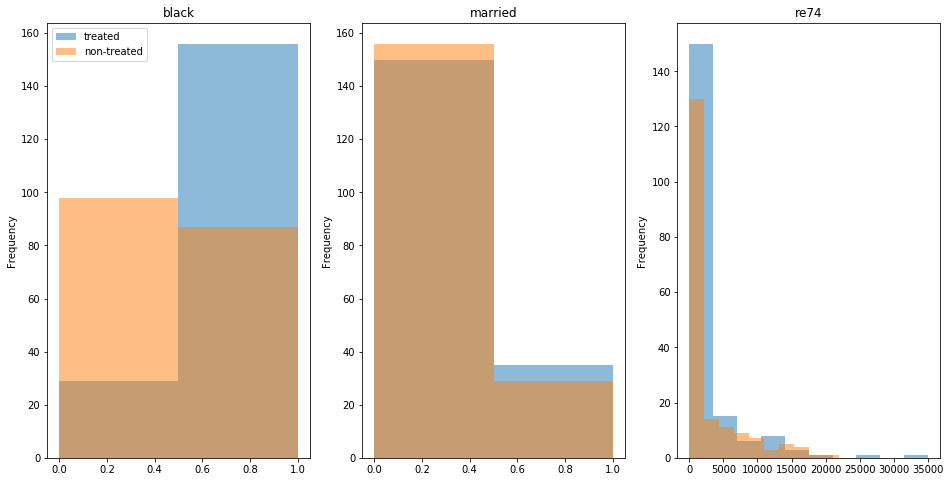

In [19]:
fig, axes = plt.subplots(1, 3)
df_treat.black.plot(kind='hist', bins=2, ax=axes[0], alpha=0.5, 
                    title='black', label='treated', figsize=(16, 8))
df_match.black.plot(kind='hist', bins=2, ax=axes[0], alpha=0.5, label='non-treated')
axes[0].legend()
df_treat.married.plot(kind='hist', bins=2, ax=axes[1], alpha=0.5,
                      title='married', label='treated')
df_match.married.plot(kind='hist', bins=2, ax=axes[1], alpha=0.5, label='non-treated')

df_treat.re74.plot(kind='hist', ax=axes[2], alpha=0.5,
                     title='re74', label='treated')
df_match.re74.plot(kind='hist', ax=axes[2], alpha=0.5, label='non-treated')

The correlations are lower and the histograms definitely show the distributions as being closer, but they're definitely not identical. The distribution of married subjects now seems spot on, but that of blacks could be improved. Any conclusions made from these sets should already be better.

Let's see what the revenue in 78 is like between these two groups:

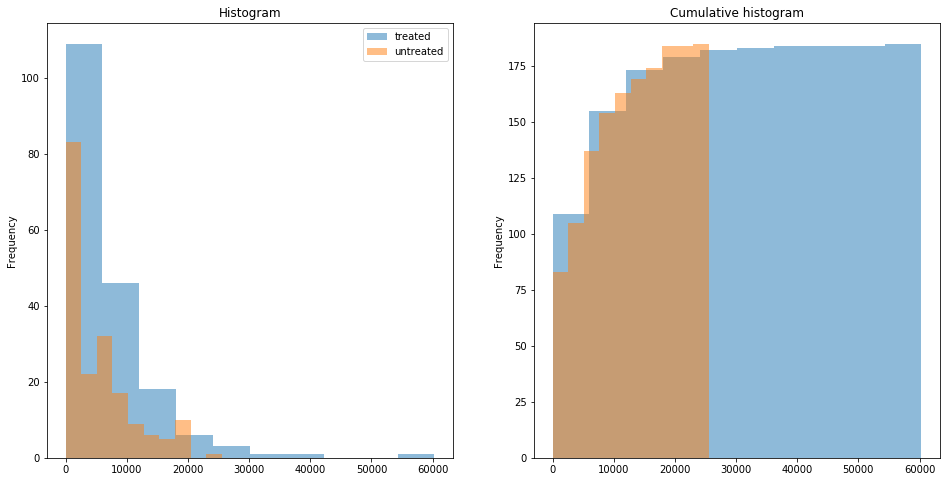

In [20]:
fig, axes = plt.subplots(1, 2)
df_treat.re78.plot(kind='hist', ax=axes[0], title='Histogram', label='treated', alpha=0.5, figsize=(16,8))
df_match.re78.plot(kind='hist', ax=axes[0], label='untreated', alpha=0.5)
axes[0].legend()

df_treat.re78.plot(kind='hist', cumulative=True, ax=axes[1], title='Cumulative histogram', label='treated', alpha=0.5)
df_match.re78.plot(kind='hist', cumulative=True, ax=axes[1], label='untreated', alpha=0.5)

It's hard to be sure from the histogram, but it looks like the treated may actually be better off. In the treated group the frequency doesn't suddenly drop off as soon as we move out of the 0-containing bin. However, looking at the cumulative histogram portrays the distributions as much more similar.

If we re-calculate our p-values we can see that it's actually gotten bigger. This may be due to our smaller groups  that we are now comparing, as we have discarded many samples from the non-treated group when performing the matching.

In [21]:
stat, pval = scipy.stats.mannwhitneyu(df_treat.re78.values, df_match.re78.values, alternative='two-sided')
print(stat,'\n',pval)

17888.0 
 0.448437498838


### 05 Balancing the groups further
We saw from the histograms that although the black and married attribute were much better balanced, the black is still rather different between both groups. If we implement the caliper in our matching, we'll discard matches which have a difference in propensity scores over a certain value. However, our sets could become a lot smaller in this way, so their significance may not be as high.

In [22]:
g1, g2 = df_treat.propensity_score, df_notreat.propensity_score
N1, N2 = df_treat.index, df_notreat.index
# Randomly permute the smaller group to get order for matching
# we'd get the same matching everytime otherwise
morder = np.random.permutation(N1)
matches = {}

caliper = 0.2
for m in morder:
    dist = abs(g1[m] - g2)
    if (dist.min() <= caliper): # a match is only assigned if the distance is under the chosen caliper value
        matches[m] = dist.argmin()    # Potential problem: check for ties
        g2 = g2.drop(matches[m])
len(matches)

116

We still have a 116 matches. Previously there were 185, so although we've lost a chunk of subjects by using stricter matching, we still have a little over a 100 to draw conclusions from.

In [23]:
g2 = df_notreat.propensity_score
g2 = g2[list(matches.values())]
g1 = df_treat.propensity_score
g1 = g1[list(matches.keys())]
# df_recompare = pd.concat([df_treat.loc[g1.index].rename(columns=lambda x: x+'_treat'), df_notreat.loc[g2.index].reset_index()], axis=1)

df_rematch = df_lalonde.loc[g2.index]
df_retreat = df_lalonde.loc[g1.index]

If we look at the histograms of our problematic attributes we now see that both 'black' and 'married' are perfectly matched. We have a one-to-one relation in both sets where we're looking at the same ratio of black and married subjects in both sets.

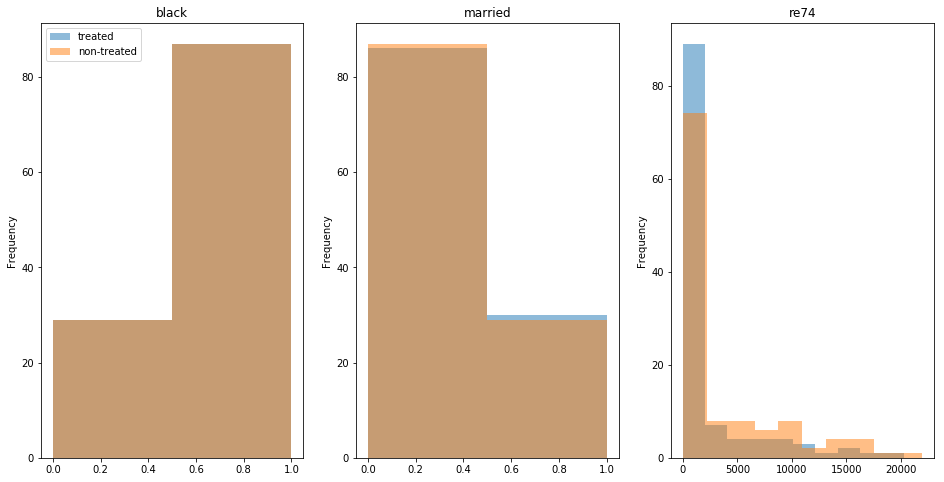

In [24]:
fig, axes = plt.subplots(1, 3)
df_retreat.black.plot(kind='hist', bins=2, ax=axes[0], alpha=0.5, 
                    title='black', label='treated', figsize=(16, 8))
df_rematch.black.plot(kind='hist', bins=2, ax=axes[0], alpha=0.5, label='non-treated')
axes[0].legend()
df_retreat.married.plot(kind='hist', bins=2, ax=axes[1], alpha=0.5,
                      title='married', label='treated')
df_rematch.married.plot(kind='hist', bins=2, ax=axes[1], alpha=0.5, label='non-treated')

df_retreat.re74.plot(kind='hist', ax=axes[2], alpha=0.5,
                     title='re74', label='treated')
df_rematch.re74.plot(kind='hist', ax=axes[2], alpha=0.5, label='non-treated')

Comparing heatmaps to the previous 'rougher' matching, we can see that the correlation between attributes and treatment has been further reduced. It also doesn't look as if we have inadvertently created correlation in other attributes, which may well happen if you attempt a manual matching instead of using propensity scores.

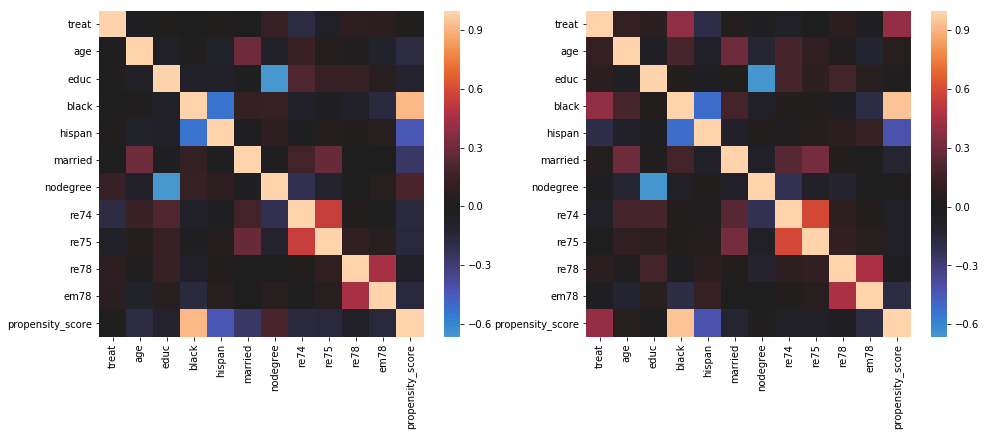

In [25]:
fig, axes = fig, axes = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(pd.concat([df_rematch, df_retreat]).corr(), center=0, ax=axes[0],
            xticklabels=df_lalonde.columns[1:], yticklabels=df_lalonde.columns[1:])
sns.heatmap(pd.concat([df_match, df_treat]).corr(), center=0, ax=axes[1],
             xticklabels=df_lalonde.columns[1:], yticklabels=df_lalonde.columns[1:])

### 06 A less naive analysis
Let's have a look at the distribution of revenues in our re-matched sets. We'll also calculate the p-value and see how it has evolved.

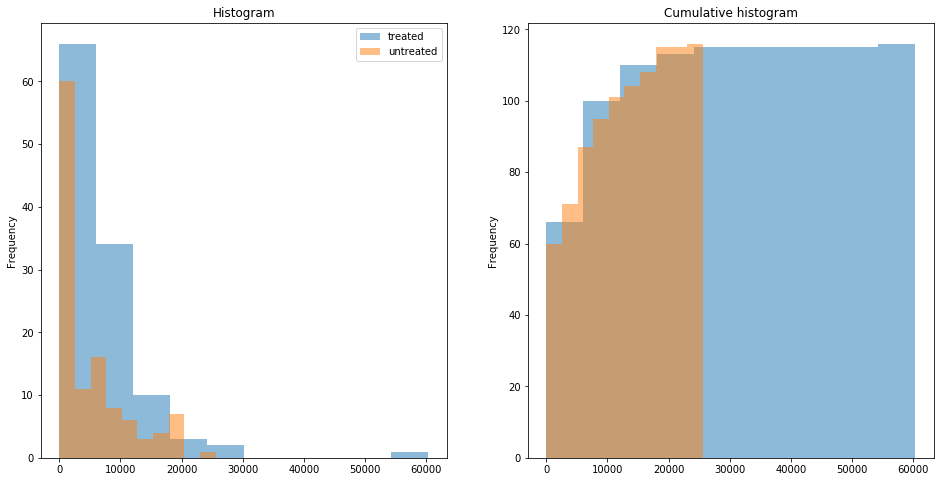

In [26]:
fig, axes = plt.subplots(1, 2)
df_retreat.re78.plot(kind='hist', ax=axes[0], title='Histogram', label='treated', alpha=0.5, figsize=(16,8))
df_rematch.re78.plot(kind='hist', ax=axes[0], label='untreated', alpha=0.5)
axes[0].legend()

df_retreat.re78.plot(kind='hist', cumulative=True, ax=axes[1], title='Cumulative histogram', label='treated', alpha=0.5)
df_rematch.re78.plot(kind='hist', cumulative=True, ax=axes[1], label='untreated', alpha=0.5)

In [27]:
stat, pval = scipy.stats.mannwhitneyu(df_retreat.re78.values, df_rematch.re78.values, alternative='two-sided')
print(stat,'\n',pval)

7613.0 
 0.0814971503643


The histograms have continued to change from the 1st matching. The steep drop-off after the first 0-containing bin now looks even less pronounced for the non-treated set, suggesting they're better off. However, the cumulative histograms now look even closer, due to the .

We could also perform a Kolmogorov-Smirnov test, which looks at the maximum difference between CDFs. This is a good statistic to evaluate if the distributions are distorted relative to one another. With the K-S test we get a bigger p-value of 0.34. But this is where we must be careful with p-values, even though we may reject the null hypothesis that the distributions are the same (based now on two tests), this doesn't imply that the alternative hypothesis is true and it definitely doesn't mean that the treatment increases the revenue of the subjects.

In [28]:
ks_2samp(df_retreat.re78.values, df_rematch.re78.values)

Ks_2sampResult(statistic=0.16379310344827586, pvalue=0.07967243741923534)

Although we could directly compare p-values, we noticed that in this case it's rather sensitive to the stricter matching that we perform. So we'll perform this matching several times and have a look at the distribution of p-values instead, hopefully we'll avoid any sort of p-value hacking in this way.

In [29]:
p = zeros(400)
pks = zeros(400)

for i in range(100):
    g1, g2 = df_treat.propensity_score, df_notreat.propensity_score
    N1, N2 = df_treat.index, df_notreat.index
    # Randomly permute the smaller group to get order for matching
    # we'd get the same matching everytime otherwise
    morder = np.random.permutation(N1)
    matches = {}

    caliper = 0.2
    for m in morder:
        dist = abs(g1[m] - g2)
        if (dist.min() <= caliper): # a match is only assigned if the distance is under the chosen caliper value
            matches[m] = dist.argmin()    # Potential problem: check for ties
            g2 = g2.drop(matches[m])
    len(matches)

    g2 = df_notreat.propensity_score
    g2 = g2[list(matches.values())]
    g1 = df_treat.propensity_score
    g1 = g1[list(matches.keys())]
    # df_recompare = pd.concat([df_treat.loc[g1.index].rename(columns=lambda x: x+'_treat'), df_notreat.loc[g2.index].reset_index()], axis=1)

    df_rematch = df_lalonde.loc[g2.index]
    df_retreat = df_lalonde.loc[g1.index]

    stat, p[i] = scipy.stats.mannwhitneyu(df_retreat.re78.values, df_rematch.re78.values, alternative='two-sided')
    stat, pks[i] = ks_2samp(df_retreat.re78.values, df_rematch.re78.values)
# print('P-value Mannfred-Whitney test:', pval, '\n P-val K-S test:', pvalks)

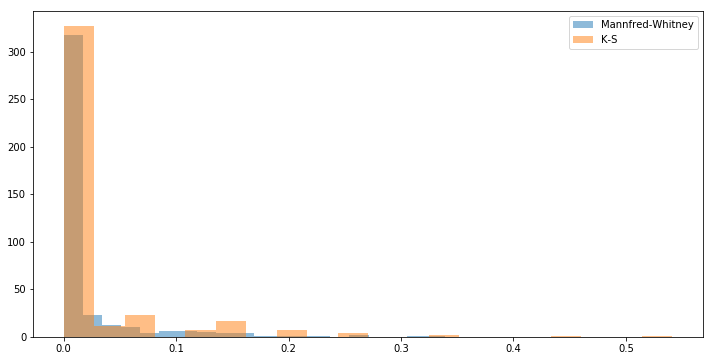

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(12,6))
plt.hist(p, alpha=0.5, bins=20, label='Mannfred-Whitney')
plt.hist(pks, alpha=0.5, bins=20, label='K-S')
plt.legend()

Happily it looks like the distribution is mostly within an accepted significance level of 0.5. There are a few outliers with large p-values, and this may very well be due to the fact that our logistic regression isn't perfect. Remember that accuracy and precision were both around 70%, meaning it is entirely possible to match subjects based on propensity scores when in fact one of the pair may not be treated.

Ideally, as our re-matched sets consist of only 116 subjects in both groups, we would need more data to draw a more solid conclusion. This has also been mentioned in the course, that amounts of data often trump sophisticated algorithms and analysis. However, with our re-matched set it does appear that there may well be some substance to the claim that the treatment did in fact increase revenue. The p-value is often small enough to reject the null hypothesis that the distributions in revenue are the same, and the histograms show a better-off treated group. More data would make it possible to decisively confirm this.

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).


2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.



In [31]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV ,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [32]:
#We fix a seed for the rest of the code
seed = 1

In [33]:
#We load the "20newsgroup" dataset
ng = fetch_20newsgroups(subset = 'all')

#Extract the features
x = ng.data
#Extract the targets 
y = ng.target
#Extract the names of the targets
names = ng.target_names

In [34]:
#We split our dataset in 4 subsets.
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.1, random_state=3, stratify = y)

#Creatingc the vectorizer in order to compute the TF_IDF.
vect_tf = TfidfVectorizer().fit(x_train)
#TF_IDF for the training set.
x_train = vect_tf.transform(x_train)
#TF_IDF for the testing set.
x_test =  vect_tf.transform(x_test)

#### Now that we have splited our dataset, let us set the model and train it on the training set and check the accuracy of our prediction over the testing set.

In [35]:
#We set the model.
alg = RandomForestClassifier()
#Training.
alg.fit(x_train, y_train)
#Prediction.
pred_y = alg.predict(x_test)
#We calculate our accuracy.
score = accuracy_score(pred_y, y_test)
score

0.65782493368700268

#### Now we want to go and try to tune the parameter in order to make better prediction.For that we will do a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth".

In [36]:
#We set the model.
alg = RandomForestClassifier()

#We give an initial value to the parameters we want to play on.
n_estimators = 100
max_depth = 50

#We also set a range of variation that we want our parameter to take
n_estimators = range(1, n_estimators, 10)
max_depth = range(1, max_depth, 5)

#We create a list of the parameters we want to tune.
tuned_parameters = {
    'n_estimators':n_estimators,
    'max_depth':max_depth
}


#We define how many fold we want to use for the cross validation.
k = 10

#We set the cross-validation
cross_fold = StratifiedKFold(10, random_state=seed, shuffle=True)

#We set the number of cores that we want to dedicate to the grid search so we can parallelize the task
num_cores = 16

#We initiate a grid and use grid search to find the optimal parameters for our model and we refit the model at the end with the obtained parameters.
best_alg = GridSearchCV(alg, tuned_parameters, cv=cross_fold, scoring='accuracy', n_jobs=num_cores, refit=True, verbose=1, return_train_score=True)

best_alg.fit(x_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:  1.0min
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  3.7min
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed: 11.5min
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed: 20.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=16,
       param_grid={'max_depth': range(1, 50, 5), 'n_estimators': range(1, 100, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [ ]:
#Now that we obtained the optimal parameters thanks to our grid search we use them to get our new prediction.
opti_alg  = best_alg.best_estimator_

#Predition over the testing set.
pred_y = opti_alg.predict(x_test)

#We calculate our new accuracy.
score = accuracy_score(pred_y, y_test)


In [ ]:
print('New accuracy with the model trained with optimal parameters:',score)

In [ ]:
#We store all the results in a dataframe
df = pd.DataFrame(best_alg.cv_results_)
df.head()

In [ ]:
#We extract the row for which the rank_test_score ==1
df_one = df[df['rank_test_score']==1]
df_one.head()

In [ ]:
#We create our confusion matrix using the dataframe we extracted before.
matrix = confusion_matrix(y_test, pred_y)
df_conf = pd.DataFrame(matrix, index = names, columns = names)
df_conf = df_conf.div(df_conf.sum(axis=1), axis=0)
#We set the window size
plt.figure(figsize=(20,7))
#We create the heatmap using our dataframe
sns.heatmap(df_conf, square=True, linecolor='w', linewidths=2, annot=False)
plt.title('Confusion Matrix')
plt.show()